In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on: {device}")

c:\Users\jcosta\Documents\ProjetoAAA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on: cuda


In [2]:
# --- Funções de Leitura de Dados ---

def read_conllu_file(filepath):
    """
    Read a CoNLL-U format file and extract words and POS tags sentence by sentence.
    
    Args:
        filepath: Path to the CoNLL-U file
        
    Returns:
        A list of dictionaries, each containing 'words' and 'pos_tags' lists for a sentence
    """
    sentences = []
    current_sentence = {'words': [], 'pos_tags': []}
    
    with open(filepath, "r", encoding="utf-8") as data_file:
        for line in data_file:
            if line.startswith("#"):
                # Skip comment lines
                pass
            elif line.strip() == "":
                # Empty line marks end of sentence
                if current_sentence['words']:  # Only add non-empty sentences
                    sentences.append(current_sentence)
                    current_sentence = {'words': [], 'pos_tags': []}
            else:
                # Parse the token line
                fields = line.split("\t")
                word, pos = fields[1], fields[3]
                current_sentence['words'].append(word)
                current_sentence['pos_tags'].append(pos)
    
    return sentences

#load data
TRAIN = "./data/en_ewt-ud-train.conllu"
DEV = "./data/en_ewt-ud-dev.conllu"
TEST = "./data/en_ewt-ud-test.conllu"

# --- 1) Carregar Dados ---
try:
    train_sents = read_conllu_file(TRAIN)
    val_sents = read_conllu_file(DEV)
    test_sents = read_conllu_file(TEST)
    print("Loaded sentences:", len(train_sents), len(val_sents), len(test_sents))
except FileNotFoundError as e:
    print(f"Erro: Ficheiro de dados não encontrado: {e.filename}. Certifique-se de que os ficheiros CoNLL-U estão em './data/'")
    exit()

# Display preview
print(f"Total sentences: {len(val_sents)}")
print(f"First 3 sentences:")
for i, sent in enumerate(val_sents[:3]):
    print(f"Sentence {i+1}:")
    print(f"  Words: {sent['words']}")
    print(f"  POS tags: {sent['pos_tags']}")

Loaded sentences: 12544 2001 2077
Total sentences: 2001
First 3 sentences:
Sentence 1:
  Words: ['From', 'the', 'AP', 'comes', 'this', 'story', ':']
  POS tags: ['ADP', 'DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']
Sentence 2:
  Words: ['President', 'Bush', 'on', 'Tuesday', 'nominated', 'two', 'individuals', 'to', 'replace', 'retiring', 'jurists', 'on', 'federal', 'courts', 'in', 'the', 'Washington', 'area', '.']
  POS tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PART', 'VERB', 'VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'PUNCT']
Sentence 3:
  Words: ['Bush', 'nominated', 'Jennifer', 'M.', 'Anderson', 'for', 'a', '15', '-', 'year', 'term', 'as', 'associate', 'judge', 'of', 'the', 'Superior', 'Court', 'of', 'the', 'District', 'of', 'Columbia', ',', 'replacing', 'Steffen', 'W.', 'Graae', '.']
  POS tags: ['PROPN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADP', 'DET', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'PROP

In [3]:
# --- Configuration ---
MAX_LEN = 128
BATCH_SIZE = 16
MODEL_NAME = 'distilbert-base-cased' # Case sensitive is usually better for POS

# --- 1. Label Mapping (Reusing from Task 1.1) ---
# We need to ensure we have the same tag map. 
# Re-running build_vocab just to be safe and self-contained
def get_tag_map(sentences):
    tags = set()
    for sent in sentences:
        for tag in sent['pos_tags']:
            tags.add(tag)
    tag2id = {tag: i for i, tag in enumerate(sorted(list(tags)))}
    id2tag = {i: tag for tag, i in tag2id.items()}
    return tag2id, id2tag

# Load data (assuming sentences are already loaded from previous task)
# train_sentences, dev_sentences, test_sentences are available
tag2id, id2tag = get_tag_map(train_sents)
num_labels = len(tag2id)

print(f" distinctive tags: {num_labels}")

# --- 2. Tokenization & Alignment Function ---
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

class TransformerPOSDataset(torch.utils.data.Dataset):
    def __init__(self, sentences, tag2id, tokenizer, max_len):
        self.sentences = sentences
        self.tag2id = tag2id
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        item = self.sentences[idx]
        word_list = item['words']
        label_list = item['pos_tags']
        
        # Tokenize the sentence
        # is_split_into_words=True tells the tokenizer we are providing a list of words
        encoding = self.tokenizer(
            word_list,
            is_split_into_words=True,
            return_offsets_mapping=True, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        # Create labels aligned with tokens
        labels = []
        encoded_labels = []
        
        # The offset mapping helps us determine which original word a token belongs to
        # It returns tuples (start, end) char indices. (0,0) usually means special token.
        doc_encodings = encoding.encodings[0]
        
        # word_ids returns a list where each element indicates the index of the word 
        # in the original sentence that the token corresponds to. 
        # None indicates special tokens like [CLS] or [SEP].
        word_ids = encoding.word_ids()
        
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                # Special token ([CLS], [SEP], [PAD]) -> Ignore (-100)
                encoded_labels.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a new word -> Use the real label
                tag = label_list[word_idx]
                encoded_labels.append(self.tag2id[tag])
            else:
                # Subsequent subword of the same word -> Ignore (-100)
                # Alternatively, you could propagate the label, but -100 is standard
                encoded_labels.append(-100)
            previous_word_idx = word_idx
            
        # Squeeze to remove batch dimension added by tokenizer
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(encoded_labels)
        
        # Remove offset_mapping as it's not needed for the model
        if 'offset_mapping' in item:
             del item['offset_mapping']
             
        return item

# Create Datasets
train_dataset = TransformerPOSDataset(train_sents, tag2id, tokenizer, MAX_LEN)
test_dataset = TransformerPOSDataset(test_sents, tag2id, tokenizer, MAX_LEN)
val_dataset = TransformerPOSDataset(val_sents, tag2id, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

 distinctive tags: 18


In [ ]:
def train_model_early_stopping(model, train_loader, val_loader,
                               NUM_EPOCHS=10, learning_rate=1e-4, device='cuda',
                               patience=2, verbose=True):
    """
    The model is trained using early stopping based on validation loss.
    patience: number of consecutive epochs with no improvement before stopping.
    If the validation loss improves, the best model weights are saved. 
    The best model weights are restored before returning.
    """
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state = None

    model.to(device)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        if verbose:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # save best model weights (in memory)
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if verbose:
                print(f"  --> Improvement. Best val loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if verbose:
                print(f"  --> No improvement for {epochs_no_improve}/{patience} epochs.")
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping triggered after epoch {epoch+1}.")
                stopped_epoch = epoch + 1
                # restore best weights before returning
                if best_state is not None:
                    model.load_state_dict({k: v.to(model.device) for k, v in best_state.items()})
                return train_losses, val_losses, stopped_epoch, model

    # training finished normally
    if best_state is not None:
        model.load_state_dict({k: v.to(model.device) for k, v in best_state.items()})
    return train_losses, val_losses, NUM_EPOCHS, model


In [11]:
model_bert = DistilBertForTokenClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels
).to(device)

print(f"Bert Model parameters: {sum(p.numel() for p in model_bert.parameters())}")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Model parameters: 65204754


In [12]:
EPOCHS = 10
LEARNING_RATE = 5e-5
PATIENCE = 1   # change to 0 to stop on first increase, or >0 to allow that many non-improving epochs

start_time = time.time()
print("Starting Fine-tuning...")

# Option A: strict immediate stop on first increase
# train_losses, val_losses, stopped_epoch, trained_model = train_model_stop_on_increase(
#     model_bert, train_loader, val_loader, EPOCHS, LEARNING_RATE, device=device)

# Option B: recommended patience-based early stopping
train_losses, val_losses, stopped_epoch, trained_model = train_model_early_stopping(
    model_bert, train_loader, val_loader,
    NUM_EPOCHS=EPOCHS, learning_rate=LEARNING_RATE,
    device=device, patience=PATIENCE, verbose=True)

training_time = time.time() - start_time
print(f"Training stopped at epoch {stopped_epoch}. Total training time: {training_time:.1f} seconds.")


Starting Fine-tuning...
Epoch [1/10]  Train Loss: 0.1962  Val Loss: 0.1135
  --> Improvement. Best val loss: 0.1135
Epoch [2/10]  Train Loss: 0.0542  Val Loss: 0.1132
  --> Improvement. Best val loss: 0.1132
Epoch [3/10]  Train Loss: 0.0285  Val Loss: 0.1237
  --> No improvement for 1/1 epochs.
Early stopping triggered after epoch 3.
Training stopped at epoch 3. Total training time: 515.3 seconds.


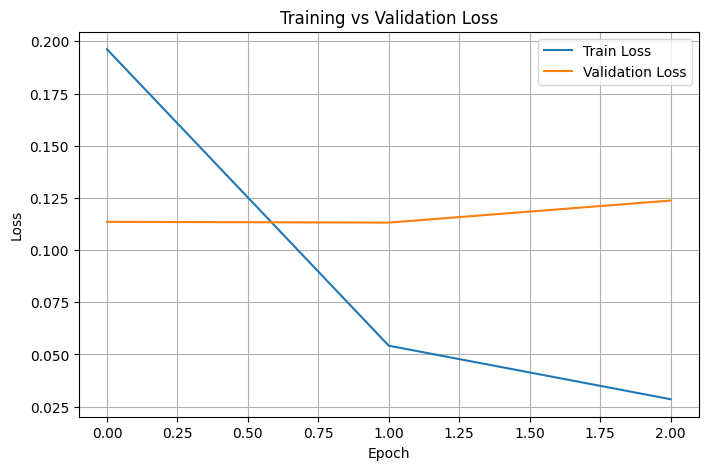

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def evaluate_model(model, loader, id2tag):
    model.eval()
    
    all_labels = []
    all_pred = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits # Shape: (batch, seq_len, num_labels)
            predictions = torch.argmax(logits, dim=2)
            
            # Flatten to align
            predictions = predictions.view(-1).cpu().numpy()
            labels = labels.view(-1).cpu().numpy()
            
            # Filter out ignored indices (-100)
            # This ensures we only evaluate on the first subword of real words
            valid_indices = labels != -100
            
            valid_preds = predictions[valid_indices]
            valid_targets = labels[valid_indices]
            
            all_labels.extend(valid_targets)
            all_pred.extend(valid_preds)

    # Convert ids back to tags
    true_tags = [id2tag[i] for i in all_labels]
    pred_tags = [id2tag[i] for i in all_pred]
    
    acc = accuracy_score(true_tags, pred_tags)
    report = classification_report(true_tags, pred_tags, zero_division=0)
    
    return acc, report

In [ ]:
acc, report = evaluate_model(model_bert, test_loader, id2tag)

print(f"Accuracy: {100*acc:.4f}%")
print(f"Training time: {training_time:.2f} seconds")
print(f"Report: \n{report}")

Accuracy: 96.8527%
Training time: 562.59 seconds
Report: 
              precision    recall  f1-score   support

         ADJ       0.95      0.93      0.94      1788
         ADP       0.99      0.97      0.98      2025
         ADV       0.94      0.95      0.95      1191
         AUX       0.99      0.99      0.99      1543
       CCONJ       1.00      0.99      0.99       736
         DET       1.00      0.99      1.00      1897
        INTJ       0.94      0.85      0.90       121
        NOUN       0.94      0.95      0.95      4123
         NUM       0.96      0.99      0.97       542
        PART       0.99      1.00      0.99       649
        PRON       0.99      0.99      0.99      2165
       PROPN       0.91      0.92      0.91      2075
       PUNCT       0.99      1.00      1.00      3096
       SCONJ       0.96      0.96      0.96       384
         SYM       0.89      0.85      0.87       113
        VERB       0.98      0.98      0.98      2606
           X       0.82